# Distracted Driver Detection

Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?

The videos can be downloaded by accessing the following link :
('/kaggle/input/state-farm-distracted-driver-detection/')


This notebook contains the Exploratory Data Analysis of the dataset and model testing of few classes.

In [1]:
# Import the Libraries..

import pickle
import numpy as np 
import datetime
import pandas as pd
import cv2
import os
import time
import scipy
import random
import seaborn as sns 
import tensorflow as tf

from random import shuffle 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import tensorflow as tf
import matplotlib.image as mpimg

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

# Keras
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv("driver_imgs_listn.csv")

In [3]:
df.head()

,subject,classname,img,Unnamed: 3
0,p002,c0,img_44733.jpg,NaN
1,p002,c0,img_72999.jpg,NaN
2,p002,c0,img_25094.jpg,NaN
3,p002,c0,img_69092.jpg,NaN
4,p002,c0,img_92629.jpg,NaN


In [4]:
df.isnull().sum()

subject           0
classname         0
img               0
Unnamed: 3    22451
dtype: int64

In [5]:
by_drivers = df.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081', 'p082'])


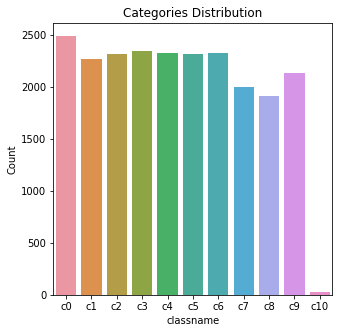

In [6]:
# Data Visulization

# Plot figure size
plt.figure(figsize = (5,5))
# Count the number of images per category
sns.countplot(x = 'classname', data = df)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

<Figure size 1440x1440 with 0 Axes>

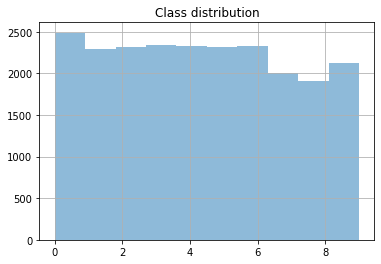

In [7]:
# Plotting class distribution
df['class_type'] = df['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
df.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [8]:
# Plot an image for each of the 11 classes. 

activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger',
                'c10':'Yawning'}

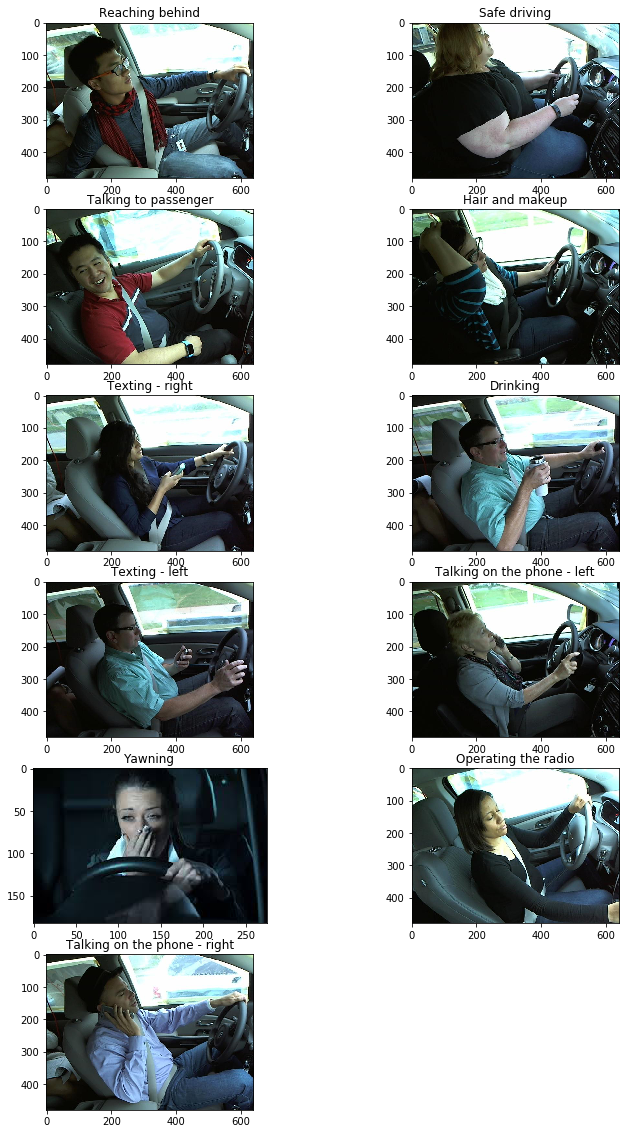

In [9]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = r"/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/train/"
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + '/' + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(6, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + '/' + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [10]:
def load_image(path, rows=None, cols=None, gray=True):
    if gray:
        img = cv2.imread(path,0)
    else:
        img = cv2.imread(path)
    if rows != None and cols != None:
        img = cv2.resize(img,(rows,cols))
    return img

In [11]:
directory = ('/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/train')
test_directory = ('/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/Ntest')
random_test = ('/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/train')
classes = ["c0","c1"]

In [12]:
img_size1 = 240
img_size2 = 240

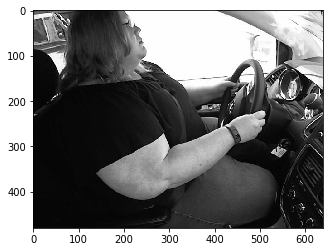

In [13]:
for i in classes:                 #train
    path = os.path.join(directory,i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

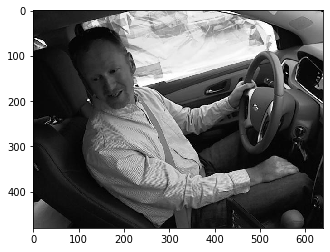

In [14]:
test_array = []
for img in os.listdir(test_directory):
    img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_GRAYSCALE)
    test_array = img_array
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break

In [15]:
print(img_array.shape)

(480, 640)


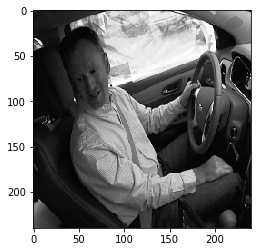

In [16]:
new_img = cv2.resize(test_array,(img_size2,img_size1))
plt.imshow(new_img,cmap='gray')
plt.show()

In [17]:
training_data = []
i = 0
print(directory)
def create_training_data():
    for category in classes:
        path = os.path.join(directory,category)
        class_num = classes.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img_array,(img_size2,img_size1))
            training_data.append([
                new_img,class_num])

/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/train


In [18]:
testing_data = []
i = 0
print(test_directory)
def create_testing_data():        
    for img in os.listdir(test_directory):
        img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_GRAYSCALE)
        new_img = cv2.resize(img_array,(img_size2,img_size1))
        testing_data.append([img,
            new_img])

/Users/apple/Desktop/Mudrika2/Driver Drowiness Detection/imgs/Ntest


In [19]:
create_training_data()

In [20]:
create_testing_data()

In [21]:
print(len(training_data))
print(len(testing_data))

4756
155


In [22]:
random.shuffle(training_data)

In [23]:
x = []
y = []
for features, label in training_data:
    x.append(features)
    y.append(label)
    

In [24]:
#X  = np.array(x[1]).reshape(-1,img_size2,img_size1,1)
#i = 1
#for i in range(len(x)):
X = np.array(x).reshape(-1,img_size2,img_size1,1)
#    X = np.append(X,Y,axis = 0)
X[0].shape
X.shape

(4756, 240, 240, 1)

In [25]:
from pandas import DataFrame
df=DataFrame(y,columns=["class"])
print(df.shape)

(4756, 1)


# Logistic Regression Model

In [26]:
print(X.shape)
x1=X.shape[:-1]
x1

(4756, 240, 240, 1)


(4756, 240, 240)

In [27]:
import numpy  
y1 = numpy.array(y) 
y1.shape

(4756,)

In [28]:
number_of_train = X.shape[0]

In [29]:
#new_img = X.reshape((X.shape[0]*X.shape[1]), X.shape[2])
X1 = X.reshape(number_of_train,X.shape[1]*X.shape[2])
X1.shape

(4756, 57600)

In [30]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(x1_train, y1_train)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# predict the response values for the observations in 

y_pred = logreg.predict(x1_test)
from sklearn import metrics
print(metrics.accuracy_score(y1_test, y_pred))

0.9957983193277311
